In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
from IPython.core.display import HTML

# Center plots
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# The 1-D Cylindrical Model

Here, we will reproduce the 1-D extraction model of Moroney et al., 2019<sup>[1]</sup>, for a bed with cylindrical geometry. We will use the `scipy.integrate` module to solve the differential equations<sup>[2]</sup>.

We start with the differential equations from Moroney's paper:

$$
\frac{\partial c_l}{\partial t} + v_l \frac{\partial c_l}{\partial z} = \frac{6 D_{v1} \alpha_{s1}}{\alpha_l d_{s1}^2} (c_{s1} - c_l) + \frac{6 D_{v2} \alpha_{s2}}{\alpha_l d_{s2}^2} (c_{s2} - c_l), \\
\frac{\partial c_{s1}}{\partial t} = -\frac{6 D_{v1}}{\phi_{v1} d_{s1}^2} (c_{s1} - c_l), \\
\frac{\partial c_{s2}}{\partial t} = -\frac{6 D_{v2}}{\phi_{v2} d_{s2}^2} (c_{s2} - c_l)
$$

We will use the method of lines, with these equations discretized in $z$. We have the following boundary conditions, adapted from those given in the paper:

$$
c_l(-1, t) = 0\;\;\;\;c_l(z, 0) = 0\;\;\;\;c_s(z, 0) = c_{s0}
$$

Here, we have moved the top boundary condition above the packed bed, rather than setting concentration in the liquid to zero for the first row of the model. This allows us to model extraction through the entire bed.

Moroney uses backward finite difference to discretize. This gives us two different update steps for $c_l$:

$$
\frac{\partial c_{l,0}}{\partial t} = -v_l \frac{c_{l,0}}{\Delta z} + \frac{6 D_{v1} \alpha_{s1}}{\alpha_l d_{s1}^2} (c_{s1,0} - c_{l,0}) + \frac{6 D_{v2} \alpha_{s2}}{\alpha_l d_{s2}^2} (c_{s2,0} - c_{l,0}), \\
\frac{\partial c_{l,n}}{\partial t} = -v_l \frac{c_{l,n} - c_{l,n-1}}{\Delta z} + \frac{6 D_{v1} \alpha_{s1}}{\alpha_l d_{s1}^2} (c_{s1,n} - c_{l,n}) + \frac{6 D_{v2} \alpha_{s2}}{\alpha_l d_{s2}^2} (c_{s2,n} - c_{l,n})
$$

and one update step for $c_{s1}$ and $c_{s2}$:

$$
\frac{\partial c_{s1,n}}{\partial t} = -\frac{6 D_{v1}}{\phi_{v1} d_{s1}^2} (c_{s1,n} - c_{l,n}), \\
\frac{\partial c_{s2,n}}{\partial t} = -\frac{6 D_{v2}}{\phi_{v2} d_{s2}^2} (c_{s2,n} - c_{l,n})
$$

Now we need to combine $c_l$, $c_{s1}$, and $c_{s2}$ into a single array. As suggested in the SciPy documentation, it is best to interleave them as:

$$
\{c_{l,0}, c_{s1,0}, c_{s2,0}, c_{l,1}, c_{s1,1}, c_{s2,1}, \ldots, c_{l,N-1}, c_{s1,N-1}, c_{s2,N-1}\}
$$

This gives a Jacobian of the form:

$$
\begin{matrix}
* & * & * & 0 & 0 & 0 & 0 & 0 & 0 \\
* & * & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
* & 0 & * & 0 & 0 & 0 & 0 & 0 & 0 \\
* & 0 & 0 & * & * & * & 0 & 0 & 0 \\
0 & 0 & 0 & * & * & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & * & 0 & * & 0 & 0 & 0 \\
0 & 0 & 0 & * & 0 & 0 & * & * & * \\
0 & 0 & 0 & 0 & 0 & 0 & * & * & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & * & 0 & * \\
0 & 0 & 0 & 0 & 0 & 0 & * & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\end{matrix}
$$

This is a banded Jacobian with `mu=2` and `ml=3` in the call to `odeint`.

Now we define functions for the diffusion terms:

In [3]:
def G(D_v, a_s, a_l, d_s, c_s, c_l):
    return (6. * D_v * a_s) / (a_l * d_s**2) * (c_s - c_l)

def H(D_v, phi_v, d_s, c_s, c_l):
    return (6. * D_v) / (phi_v * d_s**2) * (c_s - c_l)

And a function to compute the update step:

In [4]:
def update(y, t, v_l, dz, D_v1, D_v2, a_s1, a_l, d_s1, a_s2, d_s2, phi_v1, phi_v2):
    # Parse the interleaved data
    c_l = y[::3]
    c_s1 = y[1::3]
    c_s2 = y[2::3]
    
    # Initialize the return value
    dy_dt = np.empty_like(y)
    
    # Interleaved views of the return value
    dcl_dt = dy_dt[::3]
    dcs1_dt = dy_dt[1::3]
    dcs2_dt = dy_dt[2::3]
    
    # Compute derivatives
    dcl_dt[0] = -v_l * c_l[0] / dz + \
        G(D_v1, a_s1, a_l, d_s1, c_s1[0], c_l[0]) + \
        G(D_v2, a_s2, a_l, d_s2, c_s2[0], c_l[0])
    dcl_dt[1:] = -v_l * (c_l[1:] - c_l[:-1]) / dz + \
        G(D_v1, a_s1, a_l, d_s1, c_s1[1:], c_l[1:]) + \
        G(D_v2, a_s2, a_l, d_s2, c_s2[1:], c_l[1:])

    dcs1_dt[:] = -H(D_v1, phi_v1, d_s1, c_s1, c_l)
    dcs2_dt[:] = -H(D_v2, phi_v2, d_s2, c_s2, c_l)
    
    return dy_dt

Next we define some constants. Some of these come from Table 2 in the paper:

| Parameter    | Fines | Boulders |
|:------------:|:-----:|:--------:|
| $$d_s$$      | $$2.517 \times 10^{-5}\,\text{m}$$ | $$5.63 \times 10^{-4}\,\text{m}$$ |
| $$\alpha_s$$ | $$0.5$$ | $$0.3$$ |
| $$c_s$$      | $$358.587\,\text{kg}\,\text{m}^{-3}$$ | $$358.587\,\text{kg}\,\text{m}^{-3}$$ |
| $$h_{sl}$$   | $$5.1207 \times 10^{-4}\,\text{m}\,\text{s}^{-1}$$ | $$1.43 \times 10^{-3}\,\text{m}\,\text{s}^{-1}$$ |

We calculate $D_{vi}$ using the relationship:

$$
h_{sli} = \frac{D_{vi}}{d_{si}}
$$

In the paper, $D_{vi}$ is incorrectly written as $D_v$, which implies a single value for both species. Note also that $h_{sli}$ are incorrectly reported in the paper. The values given in the table need to be divided by the density of the liquid ($\rho_l = 965.3\,\text{kg}\,\text{m}^{-3}$ for water at 90 °C).

The text mentions a bean density of $\rho_s = 1400\,\text{kg}\,\text{m}^{-3}$ for the same coffees used in their experiment, intragranular porosity of $\phi_v = 0.56$, and volume fraction of soluble coffee for the fine grind of $\phi_0 = 0.143$. This gives us:

$$
c_s = \frac{\phi_0 \rho_s}{\phi_v} = \frac{(0.143)(1400\,\text{kg}\,\text{m}^{-3})}{0.56} = 357.5\,\text{kg}\,\text{m}^{-3}
$$

In describing the experimental setup, Moroney et al. define the brewing chamber as a cylinder with constant diameter of $59\,\text{mm}$. The bed height was allowed to change to accommodate the volume of coffee inserted. For the experiment we are reproducing here, the bed height was measured as $40.5\,\text{mm}$.

For these experiments, a constant flow of $Q = 250\,\text{ml}\,\text{min}^{-1}$ was maintained.

In [5]:
# Constants
a_l = 0.2
a_s1 = 0.5
a_s2 = 0.3

Q = 250. / (1e2)**3 / 60.
A = np.pi * (59e-3 / 2)**2
v_l = Q / (a_l * A)

L = 0.0405
N = 100
dz = L / N

d_s1 = 2.517e-5
d_s2 = 5.63e-4

rho_l = 965.3
h_sl1 = 5.1207e-4 / rho_l
h_sl2 = 1.43e-3 / rho_l

D_v1 = d_s1 * h_sl1
D_v2 = d_s2 * h_sl2

phi_v1 = 0.56
phi_v2 = 0.56

c_s = 358.587

# Initial values
cl_0 = np.array([0.] * N)
cs1_0 = np.array([c_s] * N)
cs2_0 = np.array([c_s] * N)

y0 = np.empty(3 * N)
y0[::3] = cl_0
y0[1::3] = cs1_0
y0[2::3] = cs2_0

# Simulation time
dt = 0.05
num_t = 250*20
t = np.linspace(0., num_t * dt, num_t)

And finally we run `odeint`:

In [6]:
sol = odeint(update, y0, t, args=(v_l, dz, D_v1, D_v2, a_s1, a_l, d_s1, a_s2, d_s2, phi_v1, phi_v2), ml=3, mu=2)
sol

array([[0.00000000e+00, 3.58587000e+02, 3.58587000e+02, ...,
        0.00000000e+00, 3.58587000e+02, 3.58587000e+02],
       [3.89685315e+00, 3.54585727e+02, 3.58084973e+02, ...,
        6.01062195e+00, 3.54594273e+02, 3.58086042e+02],
       [5.35137132e+00, 3.50657248e+02, 3.57587151e+02, ...,
        1.18576658e+01, 3.50712953e+02, 3.57594143e+02],
       ...,
       [3.98874569e-04, 4.55695428e-04, 3.16077836e-01, ...,
        7.60431218e-02, 8.61957952e-02, 8.24823333e-01],
       [3.98313305e-04, 4.55054209e-04, 3.15633076e-01, ...,
        7.59420269e-02, 8.60812187e-02, 8.23768307e-01],
       [3.97752830e-04, 4.54413893e-04, 3.15188942e-01, ...,
        7.58410662e-02, 8.59667942e-02, 8.22714626e-01]])

Let's plot the results.

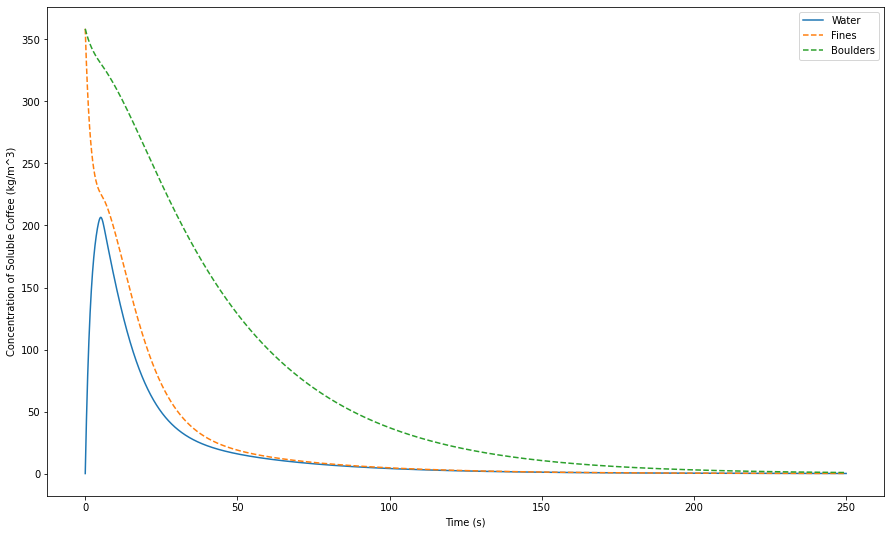

In [7]:
# Get values at the outlet
c_l = sol[:,-3]
c_s1 = sol[:,-2]
c_s2 = sol[:,-1]

# Plot the values
fig, ax = plt.subplots(figsize=(15,9))
ax.plot(t, c_l, label='Water')
ax.plot(t, c_s1, '--', label='Fines')
ax.plot(t, c_s2, '--', label='Boulders')

# Label the axes
ax.set_xlabel('Time (s)')
ax.set_ylabel('Concentration of Soluble Coffee (kg/m^3)')

# Add a legend
plt.legend()

# Plotting Experimental Data

First we read the digitized experimental data from the paper:

In [8]:
expt = pd.read_csv('fine_expt_data.csv', header=None, names=['x', 'y'])
expt.head()

,x,y
0,4.975124,211.842105
1,11.940299,150.000000
2,18.905473,76.315789
3,24.875622,43.421053
4,32.835821,27.631579


Then we repeat the plot above, adding points for the experimental results:

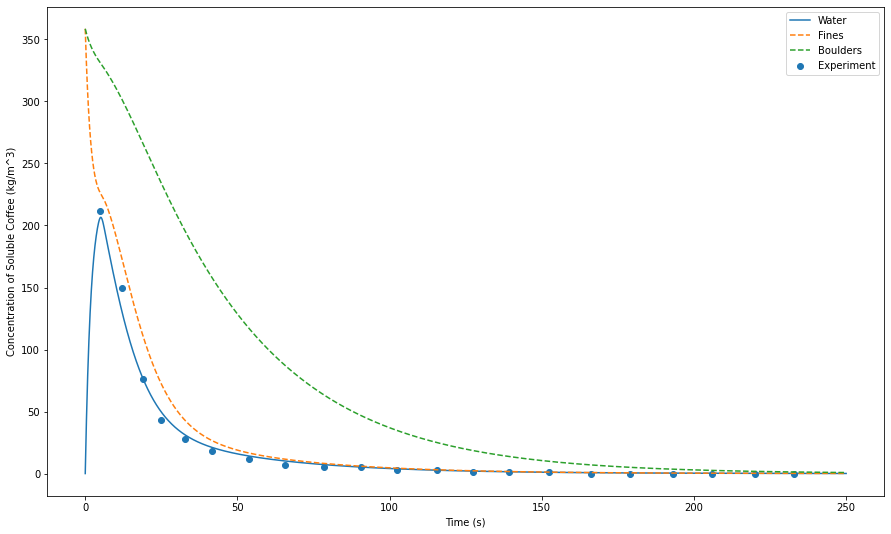

In [9]:
# Plot the values
fig, ax = plt.subplots(figsize=(15,9))
ax.plot(t, c_l, label='Water')
ax.plot(t, c_s1, '--', label='Fines')
ax.plot(t, c_s2, '--', label='Boulders')

# Plot the experimental data
ax.scatter(expt['x'], expt['y'], label='Experiment')

# Label the axes
ax.set_xlabel('Time (s)')
ax.set_ylabel('Concentration of Soluble Coffee (kg/m^3)')

# Add a legend
plt.legend()

This agrees with Figure 6(b) in the paper.

# Plotting TDS vs. EY

Now we can integrate to get the mass of solubles and liquid at the output:

In [10]:
in_s = 0.06
out_s = np.cumsum(Q * (c_l[1:] + c_l[:-1]) / 2. * dt)
out_l = Q * 1e3 * t[1:]

Then we can plot TDS vs. EY. In the plot below, I have placed a dot every 5 seconds to give a sense of time within the shot.

Text(0, 0.5, 'Total Dissolved Solids (mg/ml)')

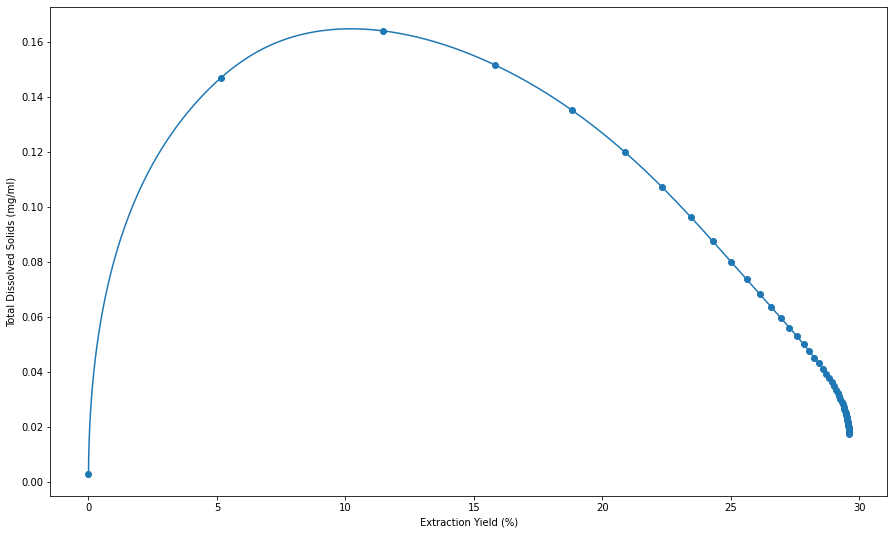

In [13]:
# Plot the values
fig, ax = plt.subplots(figsize=(15,9))
ax.plot(100. * out_s / in_s, out_s / out_l)

# Dots every 5 seconds
ax.scatter(100. * out_s[::100] / in_s, out_s[::100] / out_l[::100])

# Label the axes
ax.set_xlabel('Extraction Yield (%)')
ax.set_ylabel('Total Dissolved Solids (mg/ml)')

One of the main issues with this model is that it assumes the puck is initially wetted with clean water. However, in a normal espresso extraction, the puck is initially dry. A front of water moves through the puck, so that the first drops out of the portafilter basket have very high coffee concentration, whereas this model predicts an initial low concentration.

Our next step will be to improve on the initial conditions used in the paper, with the aim of improving the accuracy of the model early in the shot.

# References

[1] https://doi.org/10.1371/journal.pone.0219906 \
[2] https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html#solving-a-system-with-a-banded-jacobian-matrix